In [1]:
%run -i 'cosim_import.py'

0.post4535.dev0+g12f962d
2.8.0


`caseH` is the start time [H] of the co-simulation, now 10 and 18 are supported.

In [2]:
caseH = 18
ict = True
ecc = True
agc = True

%run -i 'cosim_setup_andes.py'

EVA: ts=18[H], 50000 EVs, Total Q=434.54 MWh
Online 14477, Q=362.27 MWh, SoC=0.7435
Power(MW): Pt=-39.0266, Pc=-39.0266, Pd=0.0
Ctrl: 0=7897; 1=6580; 
EVA: Load A from Aest.csv.
Working directory: "/Users/jinningwang/Documents/work/andes/jwang/notes"
> Loaded config from file "/Users/jinningwang/.andes/andes.rc"
> Loaded generated Python code in "/Users/jinningwang/.andes/pycode".
Generated code for <PQ> is stale.
Numerical code generation (rapid incremental mode) started...


Generating code for 1 models on 8 processes.


Saved generated pycode to "/Users/jinningwang/.andes/pycode"
> Reloaded generated Python code of module "pycode".
Generated numerical code for 1 models in 0.1472 seconds.
Parsing input file "/Users/jinningwang/Documents/work/andes/jwang/case/ieee39_ev2.xlsx"...
Input file parsed in 0.0660 seconds.
System internal structure set up in 0.0246 seconds.


## Load synthetic

Create load data ``d_syn``, which is a ``DataFrame`` that have three columns: ``time``, ``s10``, ``h10``. ``time`` is by seconds, ``s10`` is scalar load.

ANDES total load is: 58.564 p.u.


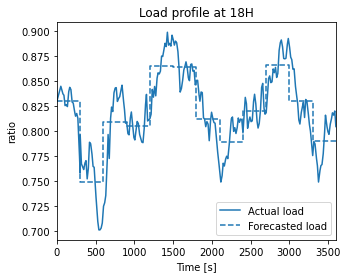

In [3]:
%run -i 'cosim_loadsyn.py'

## Setup ``ssp`` and ``ssd``

Convert ``ssa`` to pandapower net ``ssp``, add generator cost

The input cost array follow the matpower/pypower format, now only poly_cost is supported

In [4]:
%run -i 'cosim_setup_dispatch.py'
dc_comp.round(4)

-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: On
   Sparse solver: KLU
 Solution method: NR method
Numba compilation initiated with caching.
Power flow initialized in 0.0850 seconds.
0: |F(x)| = 9.601680411
1: |F(x)| = 3.49745641
2: |F(x)| = 0.1830766445
3: |F(x)| = 0.0007183028649
4: |F(x)| = 1.659287863e-08
Converged in 5 iterations in 0.0057 seconds.
Power flow results are consistent. Conversion is successful.


Set parameter Username
Academic license - for non-commercial use only - expires 2023-04-08


-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: On
   Sparse solver: KLU
 Solution method: NR method
Numba compilation initiated with caching.
Power flow initialized in 0.0053 seconds.
0: |F(x)| = 9.601680411
1: |F(x)| = 3.49745641
2: |F(x)| = 0.1830766445
3: |F(x)| = 0.0007183028649
4: |F(x)| = 1.659287863e-08
Converged in 5 iterations in 0.0044 seconds.
Power flow results are consistent. Conversion is successful.
GSF is consistent.
RTED GB model is loaded.
RTED removed: ['rampu', 'rampd']
RTED limited: sfru, sfrd
RTED: total cost=4889.131


pp cost=2184.5741560778906, gb cost=4889.131241556355


,p_mw,q_mvar,va_degree,vm_pu,p_mw(GB)
0,970.0313,39.9756,15.8831,1.0,970.0312
1,646.0000,228.9208,2.2281,1.0,646.0000
2,290.0000,81.0987,-0.8653,1.0,290.0000
3,652.0000,114.2245,7.2985,1.0,652.0000
4,508.0000,137.9576,5.4672,1.0,508.0000
5,646.6875,212.0871,6.4196,1.0,646.6875
6,232.0000,55.2884,3.4379,1.0,232.0000
7,564.0000,-59.8950,13.9534,1.0,564.0000
8,865.0000,99.7532,18.9462,1.0,865.0000
9,30.0000,0.0000,18.9462,1.0,30.0000


## Prepare

### Make link table

In [5]:
%run -i 'cosim_linktable.py'
ssa_key2

,stg_name,stg_u,stg_idx,bus_idx,dg_idx,rg_idx,rexc_idx,syg_idx,exc_idx,gov_idx,bus_name,gammap,gammaq,gen_pp,ctrl
0,PV_1,1.0,PV_1,30,False,False,False,GENROU_1,IEEEX1_1,TGOV1_1,GEN30,1.0,1.0,0,True
1,PV_2,1.0,PV_2,31,False,False,False,GENROU_2,IEEEX1_2,TGOV1_2,GEN31,1.0,1.0,1,True
2,PV_3,1.0,PV_3,32,False,False,False,GENROU_3,IEEEX1_3,TGOV1_3,GEN32,1.0,1.0,2,True
3,PV_4,1.0,PV_4,33,False,False,False,GENROU_4,IEEEX1_4,TGOV1_4,GEN33,1.0,1.0,3,True
4,PV_5,1.0,PV_5,34,False,False,False,GENROU_5,IEEEX1_5,TGOV1_5,GEN34,1.0,1.0,4,True
5,PV_6,1.0,PV_6,35,False,False,False,GENROU_6,IEEEX1_6,TGOV1_6,GEN35,1.0,1.0,5,True
6,PV_7,1.0,PV_7,36,False,False,False,GENROU_7,IEEEX1_7,TGOV1_7,GEN36,1.0,1.0,6,True
7,PV_8,1.0,PV_8,37,False,False,False,GENROU_8,IEEEX1_8,TGOV1_8,GEN37,1.0,1.0,7,True
8,PV_9,1.0,PV_9,38,False,False,False,GENROU_9,IEEEX1_9,TGOV1_9,GEN38,1.0,1.0,8,True
9,Slack_10,1.0,Slack_10,39,False,False,False,GENROU_10,IEEEX1_10,TGOV1_10,GEN39,1.0,1.0,10,True


## Loop

In the loop, there are mainly X parts:

- interval RTED: run DCOPF (``ssd.mdl``), run ACOPF(``ssp``), 

- interval AGC: do AGC, do dispatch with smooth setpoints

- interval PQ: alter load, run TDS(``ssa.TDS``)

Notes:

- The setpoints for DG are coded but not verified yet.

- After the development of ANDES control room, the dispatch and AGC part can be refactored.

- interface variables: ``DG.pmx``: DPV profile, ``DG.pref0``: setpoints, ``DG.pext0``: AGC

- ACOPF in pandapower considered generator limtis of ramping and SFR reserve

In [6]:
# Change ``rru``, ``rrd``, ``rsfr``, ``t_total`` for necessary.
t_total = 300

rru, rrd, rsfr = 1.0, 1.0, 0.05

# Define functions and constants used in loop
%run -i 'cosim_const.py'

In [7]:
%run -i 'cosim_main.py'

RTED GB model is loaded.
RTED removed: ['rampu', 'rampd']
RTED is solved.
RTED: total cost=4703.922
-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: On
   Sparse solver: KLU
 Solution method: NR method
Numba compilation initiated with caching.
Power flow initialized in 0.0035 seconds.
0: |F(x)| = 7.905038032
1: |F(x)| = 3.435488028
2: |F(x)| = 0.1810169471
3: |F(x)| = 0.001119744314
4: |F(x)| = 3.128926318e-08
Converged in 5 iterations in 0.0032 seconds.
Numba compilation initiated with caching.
GENROU (xl <= xd2) out of typical upper limit.

   idx     | values | limit
-----------+--------+------
 GENROU_1  | 0.014  | 0.001
 GENROU_3  | 0.018  | 0.003
 GENROU_4  | 0.013  | 0.001
 GENROU_5  | 0.014  | 0.001
 GENROU_7  | 0.015  | 0.002
 GENROU_8  | 0.015  | 0.006
 GENROU_9  | 0.009  | 0.001
 GENROU_10 | 0.013  | 0.000


Initialization for

Simulation to t=124.00 sec completed in 0.0299 seconds.
Simulation to t=125.00 sec completed in 0.0285 seconds.
Simulation to t=126.00 sec completed in 0.0294 seconds.
Simulation to t=127.00 sec completed in 0.0283 seconds.
Simulation to t=128.00 sec completed in 0.0284 seconds.
Simulation to t=129.00 sec completed in 0.0284 seconds.
Simulation to t=130.00 sec completed in 0.0284 seconds.
Simulation to t=131.00 sec completed in 0.0300 seconds.
Simulation to t=132.00 sec completed in 0.0284 seconds.
Simulation to t=133.00 sec completed in 0.0282 seconds.
Simulation to t=134.00 sec completed in 0.0288 seconds.
Simulation to t=135.00 sec completed in 0.0283 seconds.
Simulation to t=136.00 sec completed in 0.0291 seconds.
Simulation to t=137.00 sec completed in 0.0292 seconds.
Simulation to t=138.00 sec completed in 0.0291 seconds.
Simulation to t=139.00 sec completed in 0.0285 seconds.
Simulation to t=140.00 sec completed in 0.0290 seconds.
Simulation to t=141.00 sec completed in 0.0283 s

Simulation to t=271.00 sec completed in 0.0347 seconds.
Simulation to t=272.00 sec completed in 0.0380 seconds.
Simulation to t=273.00 sec completed in 0.0386 seconds.
Simulation to t=274.00 sec completed in 0.0388 seconds.
Simulation to t=275.00 sec completed in 0.0399 seconds.
Simulation to t=276.00 sec completed in 0.0456 seconds.
Simulation to t=277.00 sec completed in 0.0424 seconds.
Simulation to t=278.00 sec completed in 0.0381 seconds.
Simulation to t=279.00 sec completed in 0.0366 seconds.
Simulation to t=280.00 sec completed in 0.0400 seconds.
Simulation to t=281.00 sec completed in 0.0413 seconds.
Simulation to t=282.00 sec completed in 0.0400 seconds.
Simulation to t=283.00 sec completed in 0.0374 seconds.
Simulation to t=284.00 sec completed in 0.0397 seconds.
Simulation to t=285.00 sec completed in 0.0398 seconds.
Simulation to t=286.00 sec completed in 0.0397 seconds.
Simulation to t=287.00 sec completed in 0.0385 seconds.
Simulation to t=288.00 sec completed in 0.0404 s

In [8]:
# sse.tsd.iloc[30:50][['Pet', 'Ptc', 'Pt']]

(<Figure size 3600x1800 with 1 Axes>,
 <AxesSubplot:title={'center':'AGC response'}, xlabel='Time [s]', ylabel='Power (MW)'>)

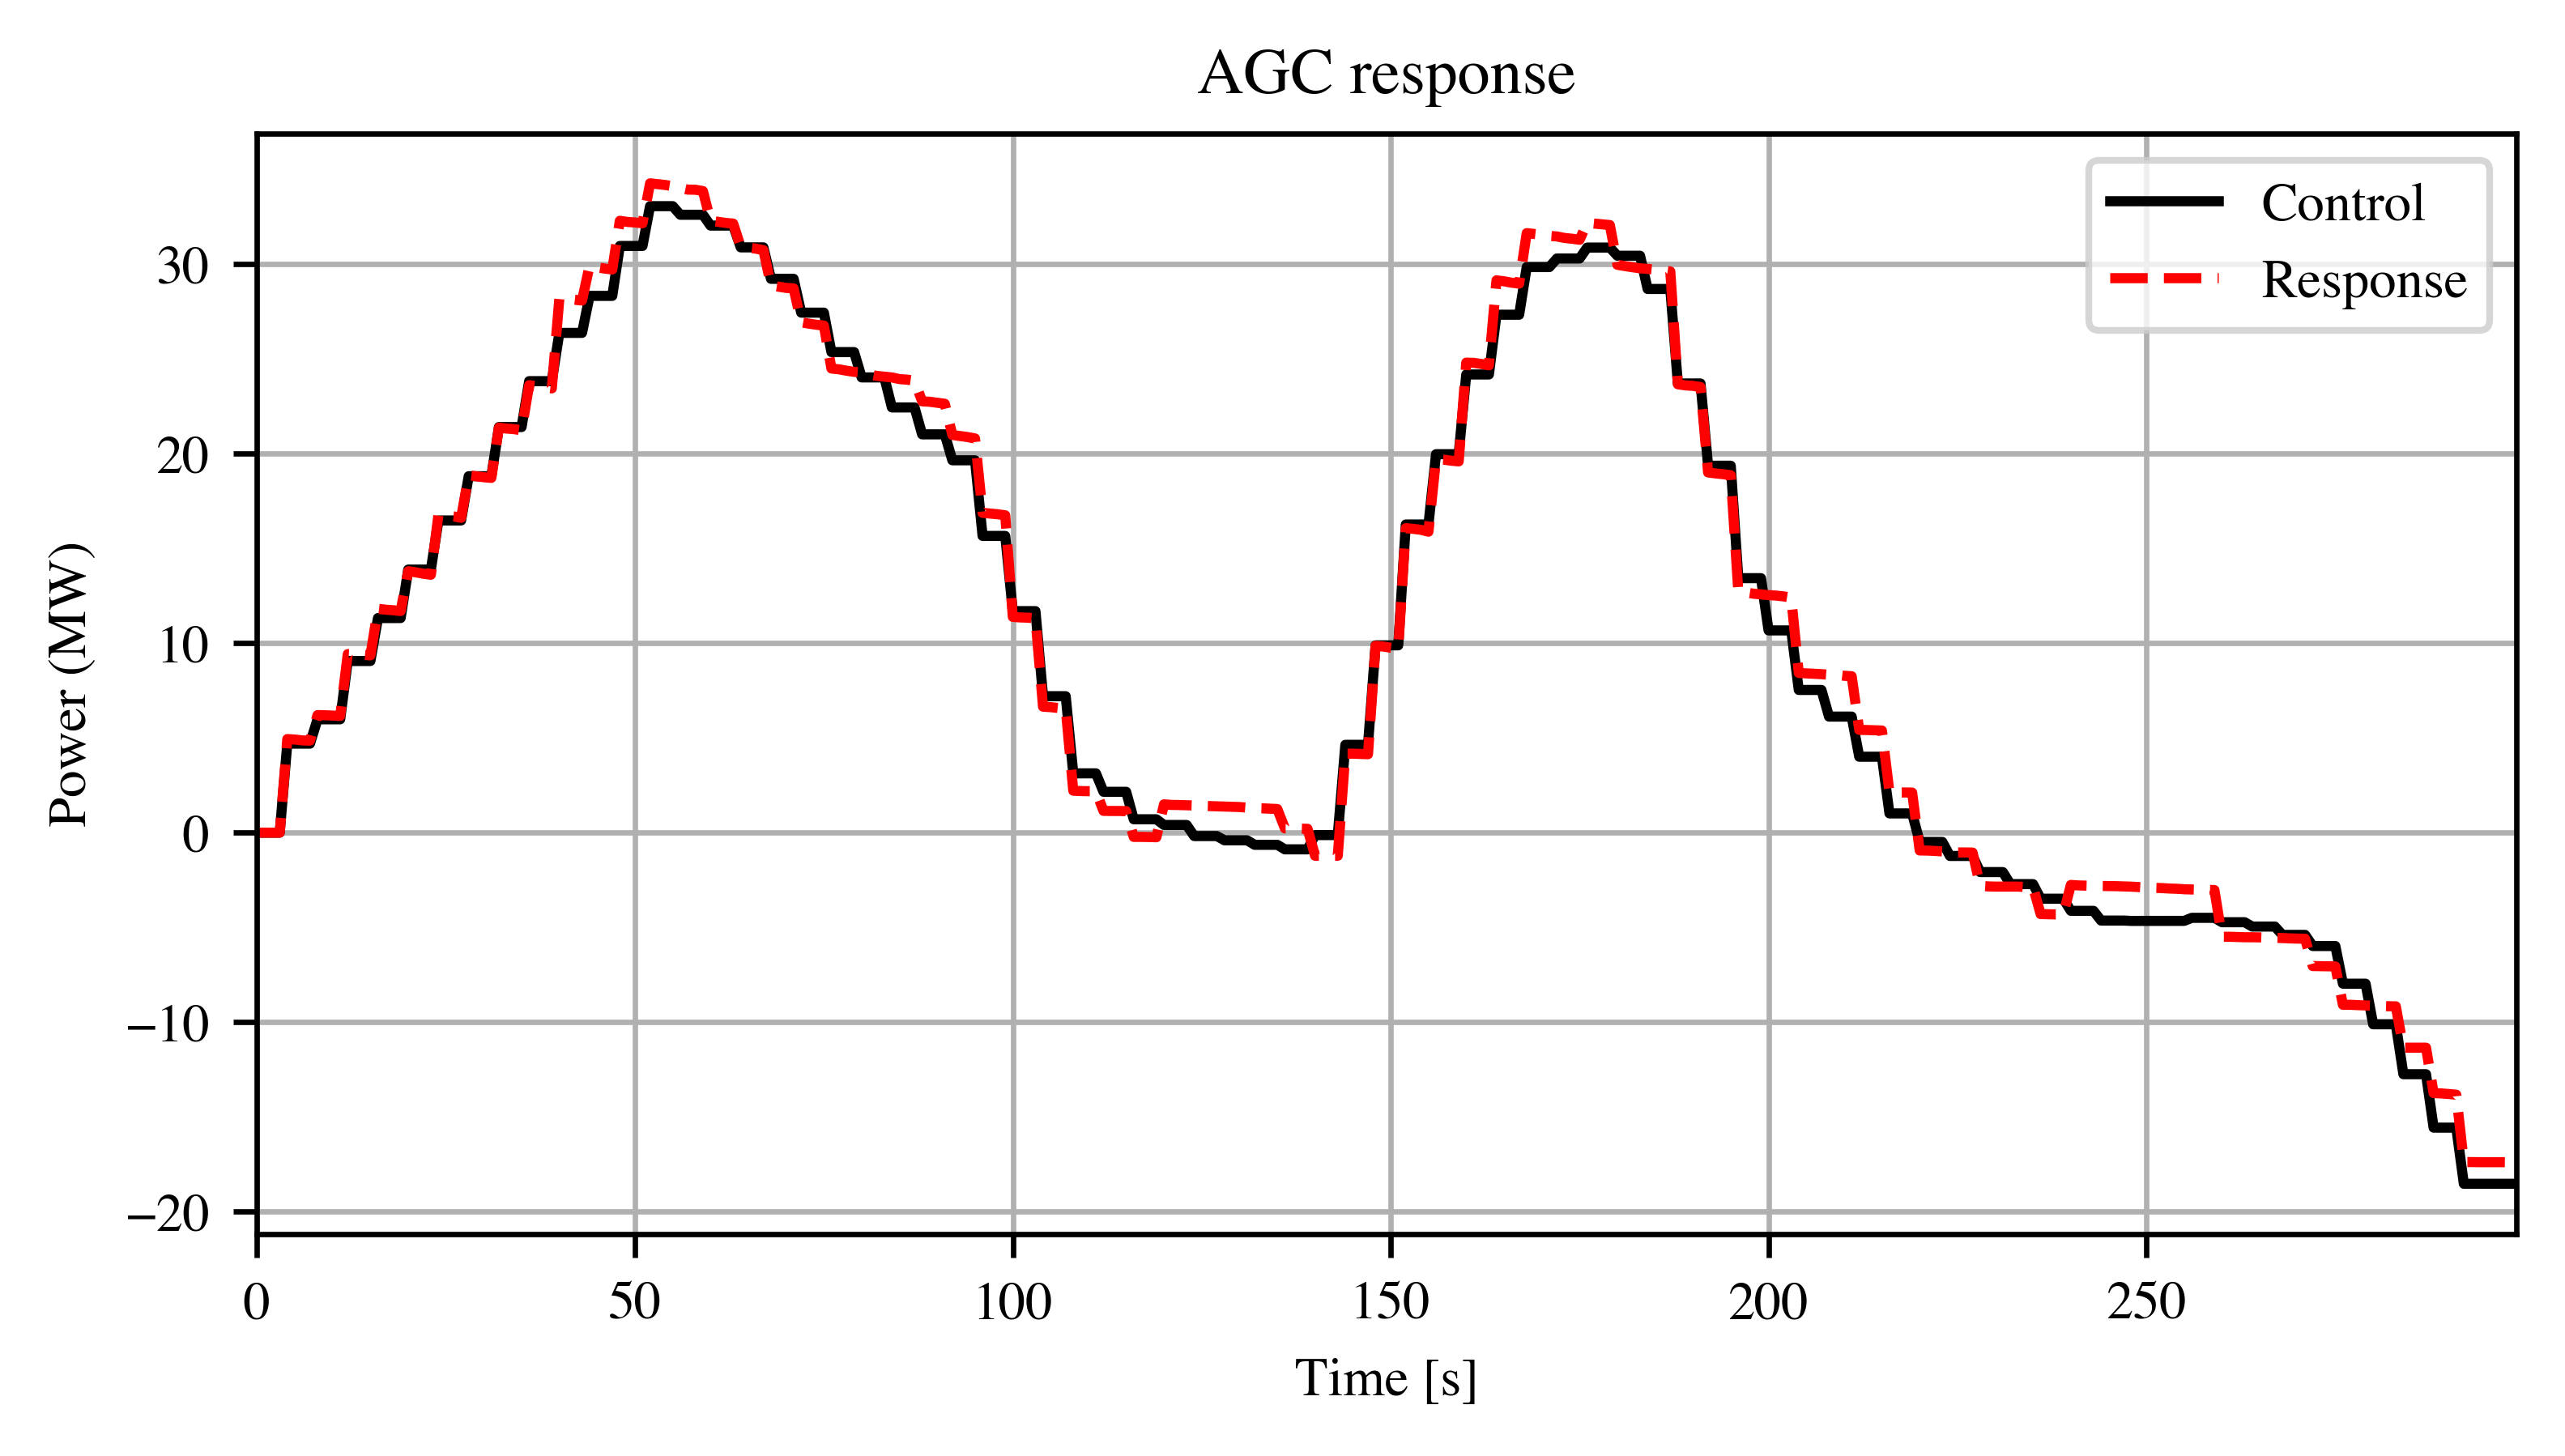

In [9]:
sse.plot_agc(style='ieee')

plt.style.use('science')
%run -i 'cosim_plotev.py'